In [1]:
# Use conda env "human_pose" for kernel
from pathlib import Path
import cv2
import numpy as np
import torch
import os

%matplotlib inline
from matplotlib import pyplot as plt

# Load and Show Original Image

Hand-Cup Example:
* 5 views

In [2]:
img_view1 = str(Path("../images/hand-cup-5-transparentbg/train/0001.png"))
img_view2 = str(Path("../images/hand-cup-5-transparentbg/train/0002.png"))
img_view3 = str(Path("../images/hand-cup-5-transparentbg/train/0003.png"))
img_view4 = str(Path("../images/hand-cup-5-transparentbg/train/0004.png"))
img_view5 = str(Path("../images/hand-cup-5-transparentbg/train/0005.png"))

(1080, 1920, 3)


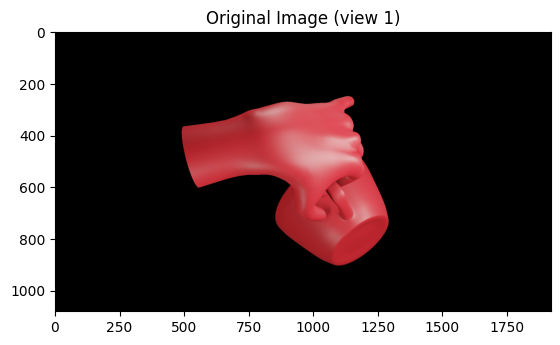

In [3]:
image1 = cv2.imread(img_view1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
print(image1.shape)
plt.title('Original Image (view 1)')
plt.imshow(image1)
plt.show()

(1080, 1920, 3)


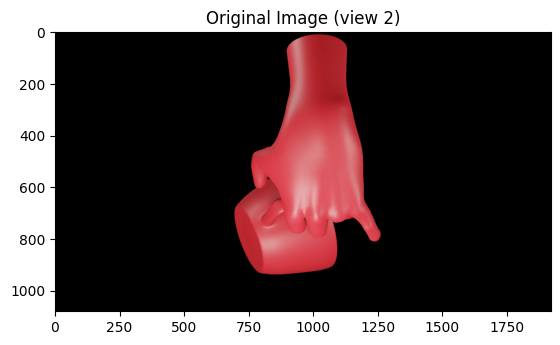

In [4]:
image2 = cv2.imread(img_view2)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
print(image2.shape)
plt.title('Original Image (view 2)')
plt.imshow(image2)
plt.show()


(1080, 1920, 3)


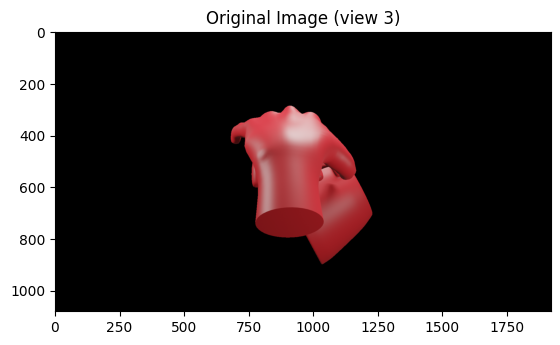

In [5]:
image3 = cv2.imread(img_view3)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
print(image3.shape)
plt.title('Original Image (view 3)')
plt.imshow(image3)
plt.show()


(1080, 1920, 3)


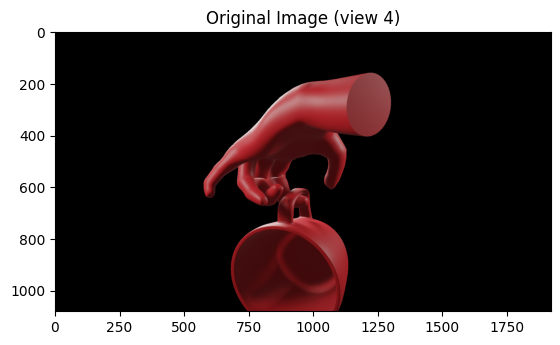

In [6]:
image4 = cv2.imread(img_view4)
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
print(image4.shape)
plt.title('Original Image (view 4)')
plt.imshow(image4)
plt.show()


(1080, 1920, 3)


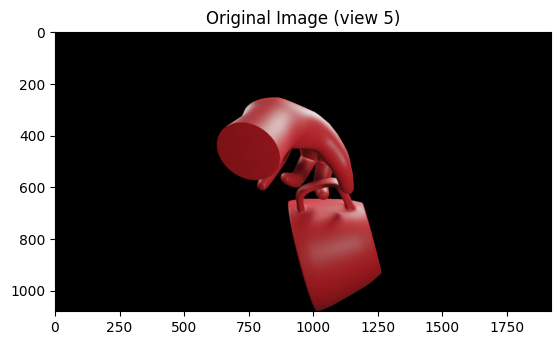

In [7]:
image5 = cv2.imread(img_view5)
image5 = cv2.cvtColor(image5, cv2.COLOR_BGR2RGB)
print(image5.shape)
plt.title('Original Image (view 5)')
plt.imshow(image5)
plt.show()


# Load SAM Model

In [8]:
# sam_checkpoint_path = str(Path("../model/sam_vit_b_01ec64.pth"))
sam_checkpoint_path = str(Path("../model/sam_vit_h_4b8939.pth"))

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

In [10]:
sam_checkpoint = sam_checkpoint_path
# model_type = "vit_b"
model_type = "vit_h"

device = "cuda"

In [11]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [12]:
predictor = SamPredictor(sam)

## Helper functions

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


# Image Embedding

In [14]:
all_images = {"view1": image1, 
              "view2": image2,
              "view3": image3,
              "view4": image4,
              "view5": image5}

In [15]:
curr_view = "view5"
curr_img = all_images[curr_view]

In [16]:
output_path = Path("output") / curr_view
if not os.path.exists(output_path):
    os.mkdir(output_path)
print(str(output_path))


output/view5


In [17]:
# Set image for the predictor
predictor.set_image(curr_img)

In [18]:
# Get image embeddings
image_embedding = predictor.features

In [19]:
# Image embedding can be viewed as a 64 x 64 256-dimensional "image"
# To visualize this "image", we need to use PCA to reduce the 256 dimensions to 3 dimensions and visualize as RGB.
print(image_embedding.shape)

torch.Size([1, 256, 64, 64])


In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [21]:
# Moves the tensor from GPU to CPU and converts it to numpy array
image_embedding_cpu = image_embedding.squeeze().cpu().numpy() # (256, 64, 64)

# Reshape for PCA
training_data = image_embedding_cpu.reshape(256, 64*64).T # (4096, 256)

# Normalize before PCA
scaled_training_data = StandardScaler().fit_transform(training_data) # (4096, 256)

# PCA to reduce to 3-dimensional data
n_components = 3
pca = PCA(n_components = n_components)

# Apply PCA
reduced_data = pca.fit_transform(scaled_training_data) # (4096, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


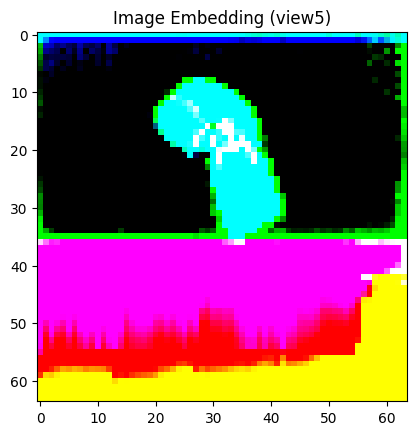

In [22]:
# Reshape the "reduced_data" for visualization
rgb_img = reduced_data.reshape(64, 64, 3)

# Visualize the tensor as a 64x64 image
plt.imshow(rgb_img)
plt.title(f'Image Embedding ({curr_view})')
plt.show()

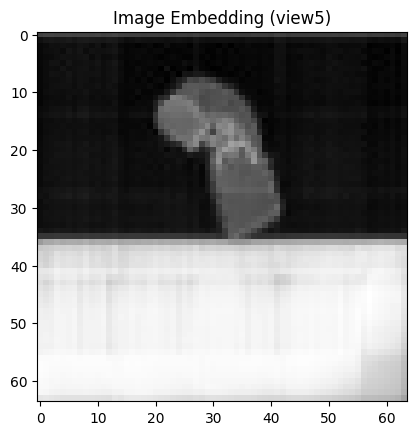

In [23]:
pca_2 = PCA(n_components = 1)
single_channel_reduced_data = pca_2.fit_transform(scaled_training_data)
single_channel_img = single_channel_reduced_data.reshape(64, 64)
# Visualize the tensor as a 64x64 image
plt.imshow(single_channel_img, cmap='gray')
plt.title(f'Image Embedding ({curr_view})')
plt.show()

# Prompt Embedding

## Prompt Point

Use a single point as prompt.

Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [24]:
if curr_view == "view1":
    input_point = np.array([[1000, 700]])
    input_label = np.array([1])
elif curr_view == "view2":
    input_point = np.array([[790, 580]])
    input_label = np.array([1])
elif curr_view == "view3":
    input_point = np.array([[1130, 530]])
    input_label = np.array([1])
elif curr_view == "view4":
    input_point = np.array([[1070, 560]])
    input_label = np.array([1])
elif curr_view == "view5":
    input_point = np.array([[1130, 590]])
    input_label = np.array([1])

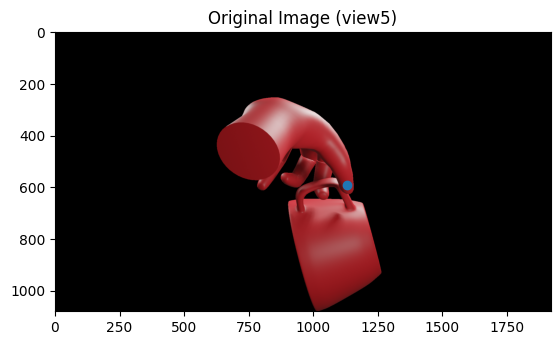

In [25]:
plt.imshow(curr_img)
plt.scatter(input_point[:, 0], input_point[:, 1], marker="o")
plt.title(f'Original Image ({curr_view})')
plt.savefig(str(output_path / "0-original-image.png"), bbox_inches='tight')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


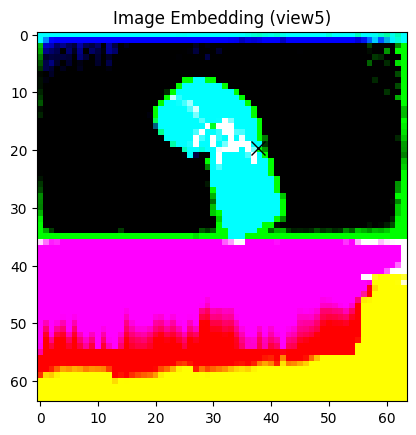

In [26]:
# Reshape the "reduced_data" for visualization
rgb_img = reduced_data.reshape(64, 64, 3)
prompt_point = input_point * np.array((64 / 1920, (64 * (1080/1920)) / 1080))

# Visualize the tensor as a 64x64 image
plt.imshow(rgb_img)
point_color = 'black'
plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=10, marker="x", color=point_color)
plt.title(f'Image Embedding ({curr_view})')
plt.savefig(str(output_path / "1-initial-image-embedding.png"), bbox_inches='tight')
plt.show()

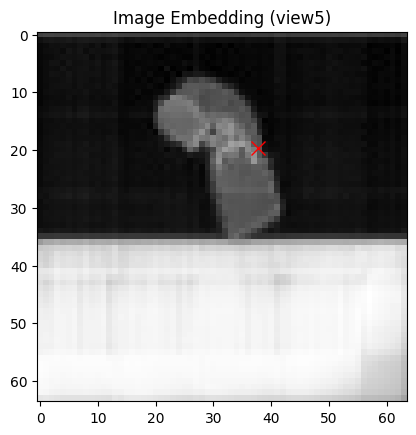

In [27]:
# Visualize the tensor as a 64x64 image
plt.imshow(single_channel_img, cmap='gray')
point_color = 'red'
plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=10, marker="x", color=point_color)
plt.title(f'Image Embedding ({curr_view})')
plt.savefig(str(output_path / "1-initial-image-embedding-gray.png"), bbox_inches='tight')
plt.show()

In [28]:
# PCA to reduce to 10-dimensional data
n_components = 10
pca_10 = PCA(n_components = n_components)

(4096, 10)


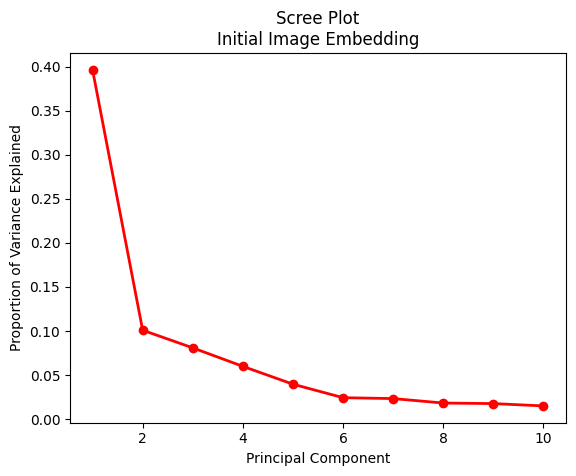

In [29]:
# Apply PCA
reduced_data_10 = pca_10.fit_transform(scaled_training_data) # (4096, 3)
print(reduced_data_10.shape)

PC_values = np.arange(pca_10.n_components_) + 1
plt.plot(PC_values, pca_10.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot\nInitial Image Embedding')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.savefig(str(output_path / "1-initial-image-embedding-pca.png"), bbox_inches='tight')
plt.show()

## Prompt Embedding

In [30]:
# input to `SamPredictor.predict()`
point_coords = input_point
point_labels = input_label
multimask_output = True

In [31]:
# inside `SamPredictor.predict()`

# Transform input prompts
coords_torch, labels_torch, box_torch, mask_input_torch = None, None, None, None

point_coords = predictor.transform.apply_coords(point_coords, predictor.original_size)
coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=predictor.device)
labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=predictor.device)
coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]

In [32]:
# input to `SamPredictor.predict_torch()`
point_coords = coords_torch
point_labels = labels_torch
boxes = box_torch
mask_input = mask_input_torch
multimask_output = multimask_output

In [33]:
print(input_point)

[[1130  590]]


In [34]:
print(1000 * (1024 / 1920))
print(700 * (1024 / 1920))

533.3333333333334
373.3333333333333


In [35]:
# inside `SamPredictor.predict_torch()`
points = (point_coords, point_labels)
print(points)


(tensor([[[602.6667, 314.6667]]], device='cuda:0'), tensor([[1]], device='cuda:0', dtype=torch.int32))


In [36]:
# Embed prompts
sparse_embeddings, dense_embeddings = predictor.model.prompt_encoder(
    points=points,
    boxes=boxes,
    masks=mask_input,
)

Only one prompt point:
* sparse_embeddings shape = [1, 2, 256]
    * 1: 1 prompt point
    * 2: fg and bg
    * 256: feature dimension

In [37]:
print(sparse_embeddings.shape)
print(dense_embeddings.shape)

torch.Size([1, 2, 256])
torch.Size([1, 256, 64, 64])


In [38]:
fg_points_embeddings = sparse_embeddings[:, 0, :]
print(fg_points_embeddings.shape)

bg_points_embeddings = sparse_embeddings[:, 1, :]
print(bg_points_embeddings.shape)

torch.Size([1, 256])
torch.Size([1, 256])


In [39]:
print(fg_points_embeddings)

tensor([[-0.0973, -0.6019,  0.7983,  1.0622,  0.5591,  1.0200,  0.0039, -0.8808,
          0.9252,  0.6862,  0.2339,  0.0723,  1.1594, -0.9344, -0.6684, -0.4376,
          1.1330, -0.4053,  0.6155,  0.9879, -0.3226, -0.4182,  0.5704, -0.9674,
         -0.1374, -0.2413, -0.0165, -0.5341,  0.2293,  1.0373,  0.0492, -0.0965,
         -0.7006, -0.3081, -0.0716,  0.6734,  0.3412,  0.5749,  0.5250, -0.2143,
          0.5489, -0.8545,  0.8084, -1.0509,  0.9125,  0.3010,  0.7887,  0.9214,
         -0.5410,  0.0486, -0.8098, -0.0173, -0.4999, -0.8911, -0.9557,  0.5212,
         -0.7898,  0.9006,  0.9722,  0.6092, -0.6290, -0.4005,  0.2418,  0.7103,
         -0.2904, -0.2496, -0.7815, -0.7225, -0.3532, -0.4719, -0.8256, -0.9302,
         -0.8863, -0.8104, -0.3915, -0.9990, -0.7901, -0.3489,  0.4875,  0.2387,
          0.4216,  0.3935,  0.8013, -0.5385, -0.8357, -0.8076, -0.9617,  0.6172,
          0.1800, -0.8272, -1.0319,  0.3991, -0.8027, -0.7330, -1.0970, -0.9553,
          1.1031,  0.7791,  

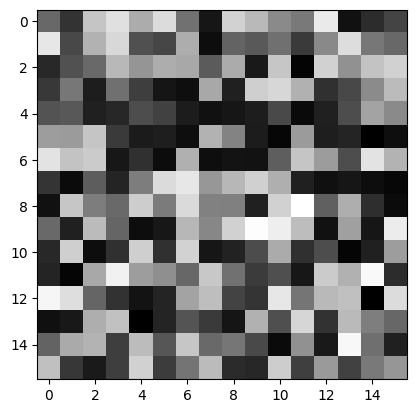

In [40]:
# Generate a random feature vector of size (1, 256)
fg_token = fg_points_embeddings.cpu().detach().numpy()
fg_token_gray = fg_token.reshape(16, 16, 1)
plt.imshow(fg_token_gray, cmap='gray')
plt.show()

# Mask Decoder

In [41]:
mask_decoder = predictor.model.mask_decoder

In [42]:
# Input to mask decoder
image_embeddings = predictor.features # [1, 256, 64, 64]
image_pe = predictor.model.prompt_encoder.get_dense_pe() # [1, 256, 64, 64]
sparse_prompt_embeddings = sparse_embeddings # [1, 2, 256]
dense_prompt_embeddings = dense_embeddings # [1, 256, 64, 64]
multimask_output = True

Visualizing image positional encoding:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


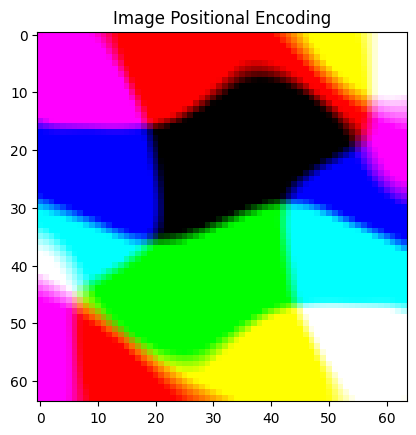

In [43]:
# Moves the tensor from GPU to CPU and converts it to numpy array
image_pe_cpu = image_pe.squeeze().cpu().numpy()
training_data_img_pe = image_pe_cpu.reshape(256, 64*64).T # 4096 x 256
training_data_img_pe = StandardScaler().fit_transform(training_data_img_pe)
img_pe_reduced_data = pca.fit_transform(training_data_img_pe)
rgb_img_pe = img_pe_reduced_data.reshape(64, 64, 3)
plt.imshow(rgb_img_pe)
plt.title('Image Positional Encoding')
plt.show()

In [44]:
# Code from `MaskDecoder.predict_masks()`

# Concatenate 1 iou token and 4 mask tokens (defined by MaskDecoder)
# 1. iou_token: [1, 256] for predicted IoU score
# 2. mask_tokens: [4, 256] for mask output
output_tokens = torch.cat([mask_decoder.iou_token.weight, mask_decoder.mask_tokens.weight], dim=0)
print(output_tokens.shape) # [5, 256]

# Expand tokens in batch direction (append first dimension, and copy 64 times along first dimension)
output_tokens = output_tokens.unsqueeze(0).expand(sparse_prompt_embeddings.size(0), -1, -1)
print(output_tokens.shape) # [1, 5, 256]

# Concatenate
# 1. iou_token: [:, 0, :] for predicted IoU score
# 2. mask_tokens: [:, 1:5, :] for mask output
# 3. sparse_prompt_embeddings: [:, 5:7, :] for the foreground and background prompt points
tokens = torch.cat((output_tokens, sparse_prompt_embeddings), dim=1)
print(tokens.shape) # [1, 7, 256]

torch.Size([5, 256])
torch.Size([1, 5, 256])
torch.Size([1, 7, 256])


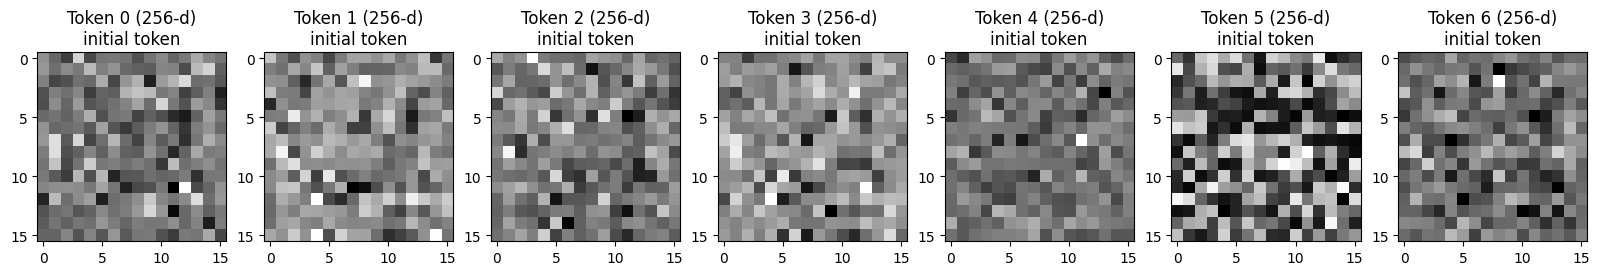

In [45]:
fig = plt.figure(figsize=(20, 3.5))
for i in range(7):
    token_i = tokens[:, i, :]
    token_i_cpu = token_i.cpu().detach().numpy() # [1, 256]
    token_i_cpu_gray = token_i_cpu.reshape(16, 16) # [16, 16]

    plt.subplot(1, 7, i+1)
    plt.title('Token %d (256-d)\ninitial token' % i)
    plt.imshow(token_i_cpu_gray, cmap='gray')

plt.savefig(str(output_path / "1-initial-tokens.png"), bbox_inches='tight')
plt.show()

In [46]:
print(image_embeddings.shape)
print(image_pe.shape)

torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 64, 64])


In [47]:
# Expand image embedding in batch direction (copy along first dimension for 64 times)
src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)
print(src.shape)

# Expand image positional encoding in batch direction (copy along first dimension for 64 times)
pos_src = torch.repeat_interleave(image_pe, tokens.shape[0], dim=0)
print(pos_src.shape)

torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 64, 64])


In [48]:
# Add dense prompt embeddings
# We are not using prompt embeddings at all, this is adding some values though.
src = src + dense_prompt_embeddings

print(src.shape)

torch.Size([1, 256, 64, 64])


In [49]:
b, c, h, w = src.shape 
print(b, c, h, w)

1 256 64 64


# Run Transformer

In [50]:
# Directly get transformer output
# hs, src = mask_decoder.transformer(src, pos_src, tokens)

## Prepare Running the 2 Decoder Blocks

In [51]:
decoder_transformer = mask_decoder.transformer

In [52]:
# For image embedding:
# 1. Flatten from dimension 2
# 2. Swap dimension 2 and dimension 1
image_embedding = src.flatten(2).permute(0, 2, 1)
print(src.shape)
print(src.flatten(2).shape)
print(image_embedding.shape)

torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 4096])
torch.Size([1, 4096, 256])


In [53]:
# For image positional encoding (same operation):
# 1. Flatten from dimension 2
# 2. Swap dimension 2 and dimension 1
image_pe = pos_src.flatten(2).permute(0, 2, 1)
print(image_pe.shape)

torch.Size([1, 4096, 256])


In [54]:
point_embedding = tokens
print(point_embedding.shape)

torch.Size([1, 7, 256])


In [55]:
# Prepare queries, keys, values for self attention and cross attention

# Cross attention from (queries: tokens) to (keys, values: image embeddings)
# 1. queries: tokens
# 2. keys, values: image embeddings
queries = point_embedding # [64, 7, 256]
keys = image_embedding # [64, 4096, 256]

In [56]:
# # Directly apply transformer
# # Apply transformer blocks and final layernorm
# for layer in decoder_transformer.layers:
#     queries, keys = layer(
#         queries=queries,
#         keys=keys,
#         query_pe=point_embedding,
#         key_pe=image_pe,
#     )

# # Apply the final attention layer from the points to the image
# q = queries + point_embedding
# k = keys + image_pe
# attn_out = decoder_transformer.final_attn_token_to_image(q=q, k=k, v=keys)
# queries = queries + attn_out
# queries = decoder_transformer.norm_final_attn(queries)

# hs, src = queries, keys

In [57]:
# There are two attention blocks
first_attention_block = decoder_transformer.layers[0]
second_attention_block = decoder_transformer.layers[1]

print(first_attention_block.skip_first_layer_pe) # i = 0 (first attention block)
print(second_attention_block.skip_first_layer_pe) # 1 = 1 (second attention block)

True
False


## First Decoder Block

In [58]:
print(first_attention_block.skip_first_layer_pe) # i = 0 (first attention block) should be True

True


In [59]:
queries = queries # point_embedding
keys = keys # image_embedding
query_pe = point_embedding
key_pe = image_pe

In [60]:
# # directly get first_attention_block output
# queries, keys = first_attention_block(
#                 queries=queries,
#                 keys=keys,
#                 query_pe=point_embedding,
#                 key_pe=image_pe,
#             )

### (1) Self attention block

In [61]:
# Self attention block
if first_attention_block.skip_first_layer_pe: # This is true
    print("Executed")
    
    # Self attention on the tokens
    # 1. queries: queries = point_embedding = tokens
    # 2. keys: queries = point_embedding = tokens 
    # 3. values: queries = point_embedding = tokens 
    queries = first_attention_block.self_attn(q=queries, k=queries, v=queries)
    
# else:
#     q = queries + query_pe
#     attn_out = first_attention_block.self_attn(q=q, k=q, v=queries)
#     queries = queries + attn_out

Executed


In [62]:
# Perform Layer Normalization (LN)
queries = first_attention_block.norm1(queries)

In [63]:
print(queries.shape)

torch.Size([1, 7, 256])


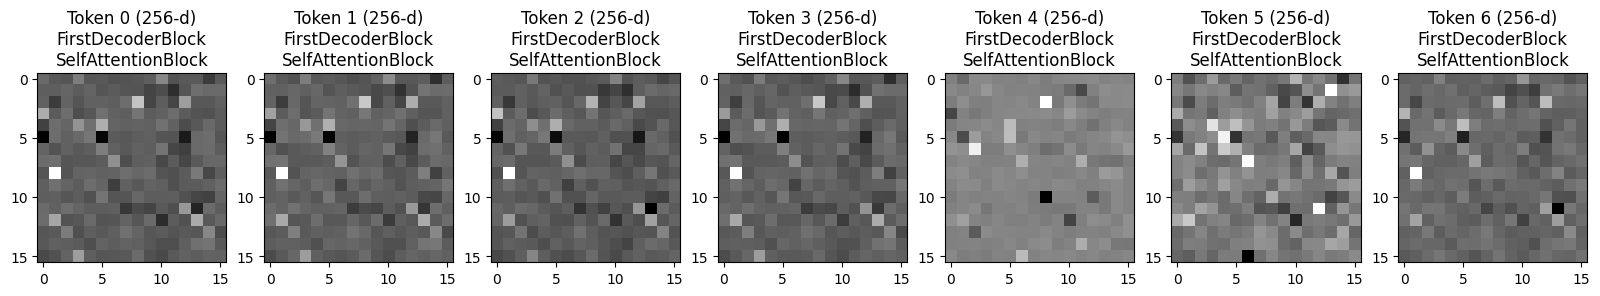

In [64]:
fig = plt.figure(figsize=(20, 3.5))
for i in range(7):
    updated_token_i = queries[:, i, :]
    updated_token_i_cpu = updated_token_i.cpu().detach().numpy() # [1, 256]
    updated_token_i_cpu_gray = updated_token_i_cpu.reshape(16, 16) # [16, 16]

    plt.subplot(1, 7, i+1)
    plt.title('Token %d (256-d)\nFirstDecoderBlock\nSelfAttentionBlock' % i)
    plt.imshow(updated_token_i_cpu_gray, cmap='gray')

plt.savefig(str(output_path / "2-1-decoder1-step1-tokens.png"), bbox_inches='tight')
plt.show()

### (2) Cross attention block, from tokens (as queries) to the image embedding

In [65]:
q = queries + query_pe # tokens + point_embedding
k = keys + key_pe # image embedding + image_pe
v = keys # image embedding

# Cross attention from tokens (as queries) to image embedding
# 1. q = tokens + point_embedding (tokens)
# 2. k = image embedding + image_pe (image)
# 3. v = image embedding (image)
attn_out = first_attention_block.cross_attn_token_to_image(q=q, k=k, v=keys)

queries = queries + attn_out
queries = first_attention_block.norm2(queries)

In [66]:
print(queries.shape)

torch.Size([1, 7, 256])


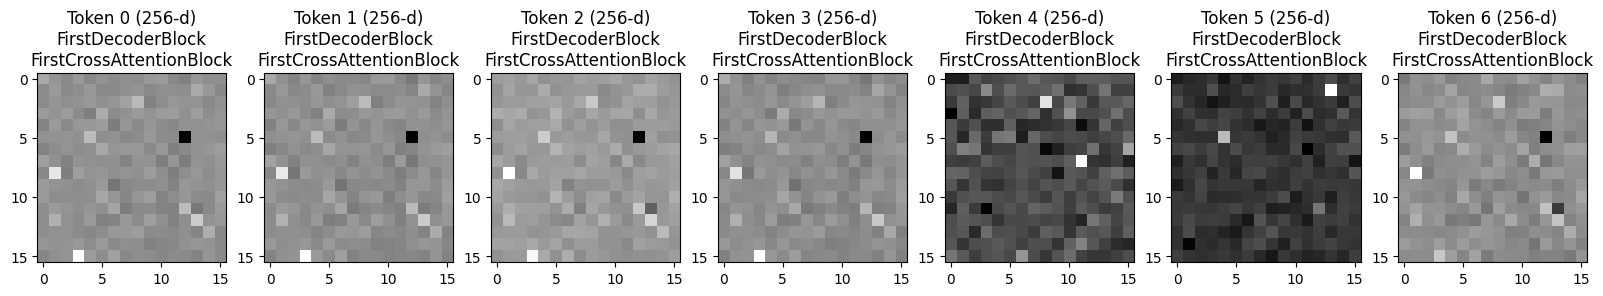

In [67]:
fig = plt.figure(figsize=(20, 3.5))
for i in range(7):
    updated_token_i = queries[:, i, :]
    updated_token_i_cpu = updated_token_i.cpu().detach().numpy() # [1, 256]
    updated_token_i_cpu_gray = updated_token_i_cpu.reshape(16, 16) # [16, 16]

    plt.subplot(1, 7, i+1)
    plt.title('Token %d (256-d)\nFirstDecoderBlock\nFirstCrossAttentionBlock' % i)
    plt.imshow(updated_token_i_cpu_gray, cmap='gray')
plt.savefig(str(output_path / "2-2-decoder1-step2-tokens.png"), bbox_inches='tight')
plt.show()

### (3) MLP block, a point-wise MLP updates each token

In [68]:
mlp_out = first_attention_block.mlp(queries)
queries = queries + mlp_out
queries = first_attention_block.norm3(queries)

In [69]:
print(queries.shape)

torch.Size([1, 7, 256])


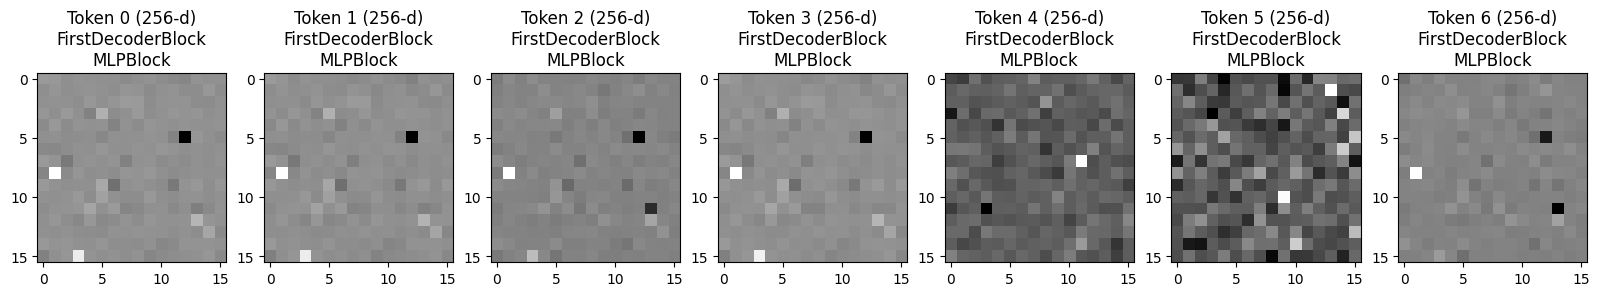

In [70]:
fig = plt.figure(figsize=(20, 3.5))
for i in range(7):
    updated_token_i = queries[:, i, :]
    updated_token_i_cpu = updated_token_i.cpu().detach().numpy() # [1, 256]
    updated_token_i_cpu_gray = updated_token_i_cpu.reshape(16, 16) # [16, 16]

    plt.subplot(1, 7, i+1)
    plt.title('Token %d (256-d)\nFirstDecoderBlock\nMLPBlock' % i)
    plt.imshow(updated_token_i_cpu_gray, cmap='gray')
plt.savefig(str(output_path / "2-3-decoder1-step3-tokens.png"), bbox_inches='tight')
plt.show()

### (4) Cross attention block, from image embedding (as queries) to tokens

In [71]:
# Cross attention block, image embedding attending to tokens
q = queries + query_pe # tokens + point_embedding
k = keys + key_pe # image_embedding + image_pe

# Cross attention from iamge embedding (as queries) to tokens
# 1. queries = k = image_embedding + image_pe (image)
# 2. keys = q = tokens + point_embedding (tokens)
# 3. values = queries = tokens (tokens)
attn_out = first_attention_block.cross_attn_image_to_token(q=k, k=q, v=queries)
keys = keys + attn_out
keys = first_attention_block.norm4(keys)

In [72]:
print(keys.shape)

torch.Size([1, 4096, 256])


In [73]:
updated_image_embeddidng1 = keys
print(updated_image_embeddidng1.shape)

torch.Size([1, 4096, 256])


In [74]:
print(input_point)

[[1130  590]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4096, 3)


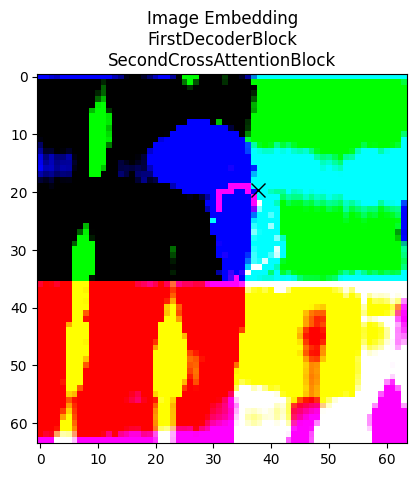

In [75]:
src_i = updated_image_embeddidng1[0, :, :] # [4096, 256]
src_i_cpu = src_i.squeeze().cpu().detach().numpy()
prompt_point = input_point * np.array((64 / 1920, (64 * (1080/1920)) / 1080))
training_data_src_i = src_i_cpu
reduced_data_src_i = pca.fit_transform(StandardScaler().fit_transform(training_data_src_i))
print(reduced_data_src_i.shape)
rgb_src_i = reduced_data_src_i.reshape(64, 64, 3)

plt.imshow(rgb_src_i)
point_color = 'black'
plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=10, marker="x", color=point_color)
plt.title('Image Embedding\nFirstDecoderBlock\nSecondCrossAttentionBlock')
plt.savefig(str(output_path / "2-4-decoder1-step4-image-embedding.png"), bbox_inches='tight')
plt.show()

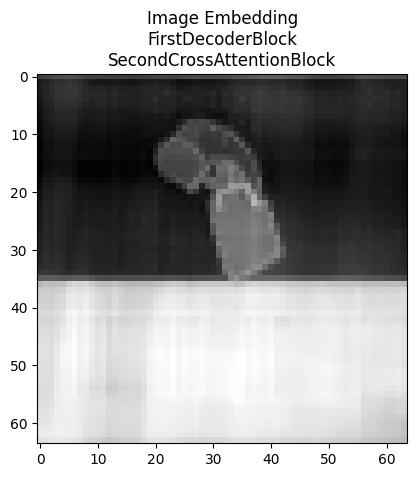

In [76]:
reduced_data_src_i_2 = pca_2.fit_transform(StandardScaler().fit_transform(training_data_src_i))
rgb_src_i_2 = reduced_data_src_i_2.reshape(64, 64)
# Visualize the tensor as a 64x64 image
plt.imshow(rgb_src_i_2, cmap='gray')
plt.title('Image Embedding\nFirstDecoderBlock\nSecondCrossAttentionBlock')
plt.savefig(str(output_path / "2-4-decoder1-step4-image-embedding-gray.png"), bbox_inches='tight')
plt.show()

(4096, 10)


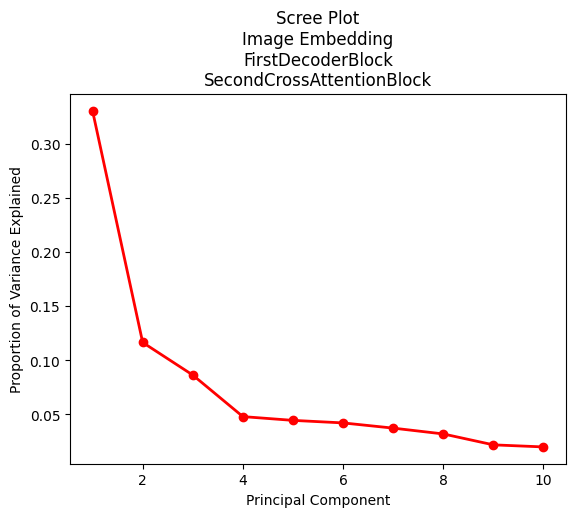

In [77]:
# Apply PCA
reduced_data_10 = pca_10.fit_transform(StandardScaler().fit_transform(training_data_src_i)) # (4096, 3)
print(reduced_data_10.shape)

PC_values = np.arange(pca_10.n_components_) + 1
plt.plot(PC_values, pca_10.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot\nImage Embedding\nFirstDecoderBlock\nSecondCrossAttentionBlock')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.savefig(str(output_path / "2-4-decoder1-step4-image-embedding-pca.png"), bbox_inches='tight')
plt.show()

## Second Decoder Block

In [78]:
print(second_attention_block.skip_first_layer_pe) # i = 1 (second attention block) should be False

False


In [79]:
queries = queries # updated tokens
keys = keys # updated image_embedding
query_pe = point_embedding 
key_pe = image_pe

In [80]:
# # directly get second_attention_block output
# queries, keys = second_attention_block(
#                 queries=queries,
#                 keys=keys,
#                 query_pe=point_embedding,
#                 key_pe=image_pe,
#             )

### (1) Self attention block

In [81]:
if second_attention_block.skip_first_layer_pe: # This is False
    # queries = first_attention_block.self_attn(q=queries, k=queries, v=queries)
    pass
else:
    print("Executed")

    # Self attention on the tokens
    # 1. q: updated queries + query positional encoding
    # 2. k: q
    # 3. v: updated queries
    q = queries + query_pe
    attn_out = second_attention_block.self_attn(q=q, k=q, v=queries)
    queries = queries + attn_out

Executed


In [82]:
queries = second_attention_block.norm1(queries)

In [83]:
print(queries.shape)

torch.Size([1, 7, 256])


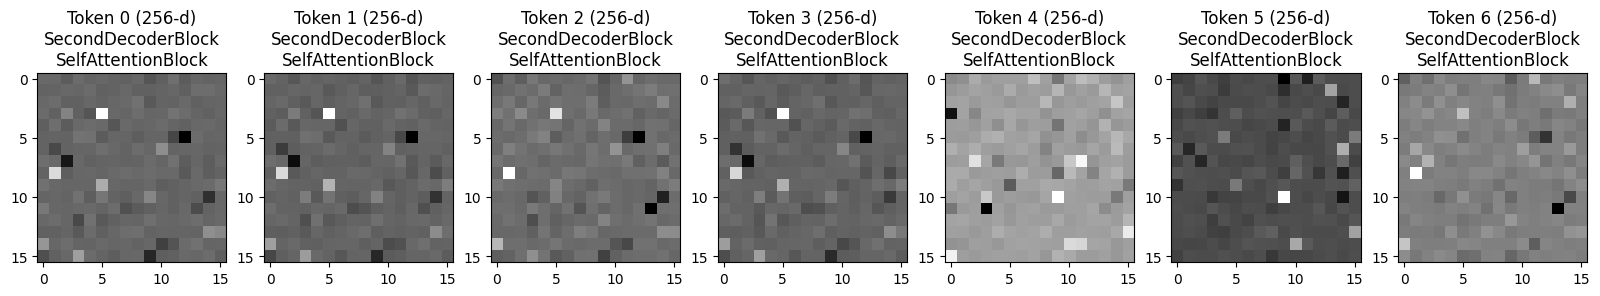

In [84]:
fig = plt.figure(figsize=(20, 3.5))
for i in range(7):
    updated_token_i = queries[:, i, :]
    updated_token_i_cpu = updated_token_i.cpu().detach().numpy() # [1, 256]
    updated_token_i_cpu_gray = updated_token_i_cpu.reshape(16, 16) # [16, 16]

    plt.subplot(1, 7, i+1)
    plt.title('Token %d (256-d)\nSecondDecoderBlock\nSelfAttentionBlock' % i)
    plt.imshow(updated_token_i_cpu_gray, cmap='gray')

plt.savefig(str(output_path / "3-1-decoder2-step1-tokens.png"), bbox_inches='tight')
plt.show()

### (2) Cross attention block, from tokens (as queries) to the image embedding

In [85]:
q = queries + query_pe # tokens + point_embedding
k = keys + key_pe # image embedding + image_pe
v = keys # image embedding

# Cross attention from tokens (as queries) to image embedding
# 1. q = tokens + point_embedding (tokens)
# 2. k = image embedding + image_pe (image)
# 3. v = image embedding (image)
attn_out = second_attention_block.cross_attn_token_to_image(q=q, k=k, v=keys)

queries = queries + attn_out
queries = second_attention_block.norm2(queries)

In [86]:
print(queries.shape)

torch.Size([1, 7, 256])


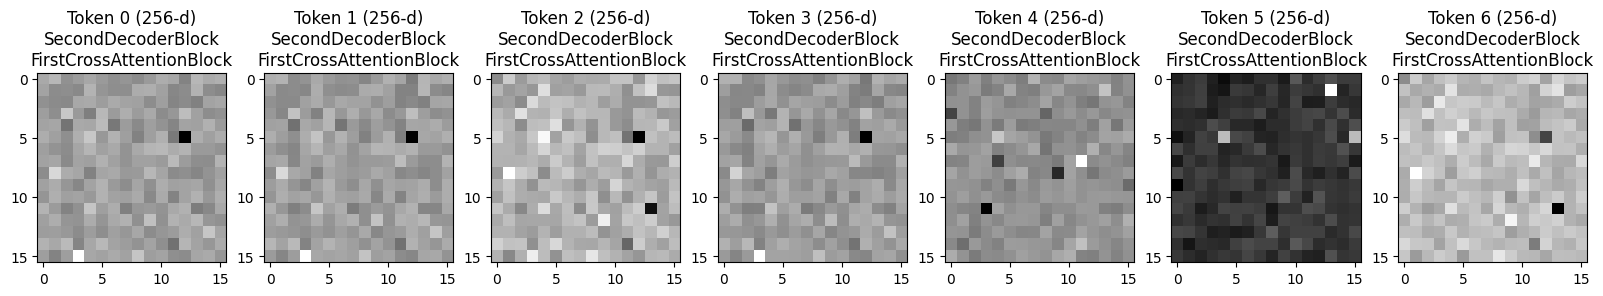

In [87]:
fig = plt.figure(figsize=(20, 3.5))
for i in range(7):
    updated_token_i = queries[:, i, :]
    updated_token_i_cpu = updated_token_i.cpu().detach().numpy() # [1, 256]
    updated_token_i_cpu_gray = updated_token_i_cpu.reshape(16, 16) # [16, 16]

    plt.subplot(1, 7, i+1)
    plt.title('Token %d (256-d)\nSecondDecoderBlock\nFirstCrossAttentionBlock' % i)
    plt.imshow(updated_token_i_cpu_gray, cmap='gray')
plt.savefig(str(output_path / "3-2-decoder2-step2-tokens.png"), bbox_inches='tight')
plt.show()

### (3) MLP block, a point-wise MLP updates each token

In [88]:
mlp_out = second_attention_block.mlp(queries)
queries = queries + mlp_out
queries = second_attention_block.norm3(queries)

In [89]:
print(queries.shape)

torch.Size([1, 7, 256])


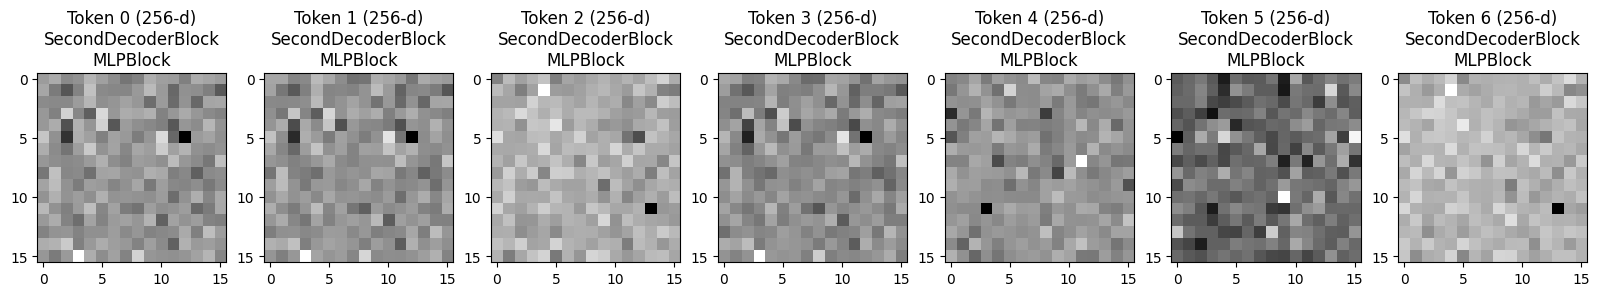

In [90]:
fig = plt.figure(figsize=(20, 3.5))
for i in range(7):
    updated_token_i = queries[:, i, :]
    updated_token_i_cpu = updated_token_i.cpu().detach().numpy() # [1, 256]
    updated_token_i_cpu_gray = updated_token_i_cpu.reshape(16, 16) # [16, 16]

    plt.subplot(1, 7, i+1)
    plt.title('Token %d (256-d)\nSecondDecoderBlock\nMLPBlock' % i)
    plt.imshow(updated_token_i_cpu_gray, cmap='gray')
plt.savefig(str(output_path / "3-3-decoder2-step3-tokens.png"), bbox_inches='tight')
plt.show()

### (4) Cross attention block, from image embedding (as queries) to tokens

In [91]:
# Cross attention block, image embedding attending to tokens
q = queries + query_pe # tokens + point_embedding
k = keys + key_pe # image_embedding + image_pe

# Cross attention from iamge embedding (as queries) to tokens
# 1. queries = k = image_embedding + image_pe (image)
# 2. keys = q = tokens + point_embedding (tokens)
# 3. values = queries = tokens (tokens)
attn_out = second_attention_block.cross_attn_image_to_token(q=k, k=q, v=queries)
keys = keys + attn_out
keys = second_attention_block.norm4(keys)

In [92]:
print(keys.shape)

torch.Size([1, 4096, 256])


In [93]:
updated_image_embeddidng2 = keys
print(updated_image_embeddidng2.shape)

torch.Size([1, 4096, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4096, 3)


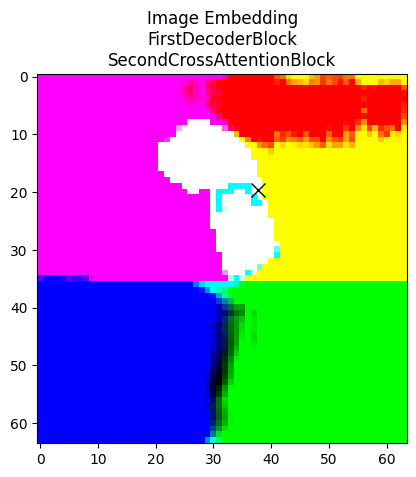

In [94]:
src_i2 = updated_image_embeddidng2[0, :, :] # [4096, 256]
src_i_cpu2 = src_i2.squeeze().cpu().detach().numpy()
prompt_point = input_point * np.array((64 / 1920, (64 * (1080/1920)) / 1080))
training_data_src_i2 = src_i_cpu2
reduced_data_src_i2 = pca.fit_transform(StandardScaler().fit_transform(training_data_src_i2))
print(reduced_data_src_i2.shape)
rgb_src_i2 = reduced_data_src_i2.reshape(64, 64, 3)

plt.imshow(rgb_src_i2)
point_color = 'black'
plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=10, marker="x", color=point_color)
plt.title('Image Embedding\nFirstDecoderBlock\nSecondCrossAttentionBlock')
plt.show()

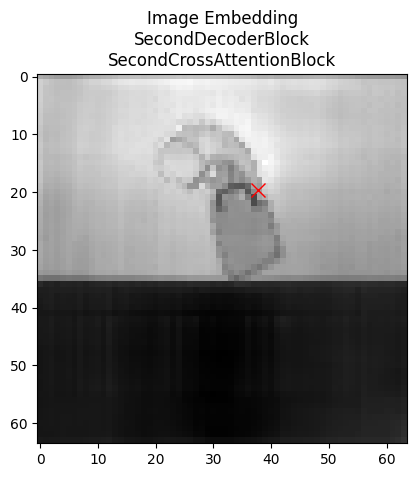

In [95]:
reduced_data_src_i_22 = pca_2.fit_transform(StandardScaler().fit_transform(training_data_src_i2))
rgb_src_i_22 = reduced_data_src_i_22.reshape(64, 64)
# Visualize the tensor as a 64x64 image
plt.imshow(rgb_src_i_22, cmap='gray')
plt.title('Image Embedding\nSecondDecoderBlock\nSecondCrossAttentionBlock')
point_color = "red"
plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=10, marker="x", color=point_color)
plt.show()

## Final attention layer from the points (as queries) to the image

In [96]:
# Apply the final attention layer from the points to the image
q = queries + point_embedding
k = keys + image_pe
attn_out = decoder_transformer.final_attn_token_to_image(q=q, k=k, v=keys)
queries = queries + attn_out
queries = decoder_transformer.norm_final_attn(queries)

In [97]:
# This is the final output of `transformer()`
hs, src =  queries, keys

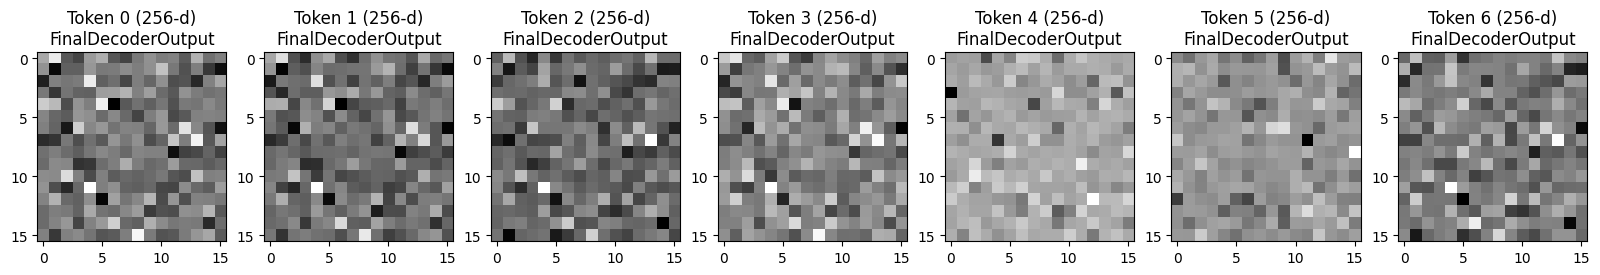

In [98]:
fig = plt.figure(figsize=(20, 3.5))
for i in range(7):
    updated_token_i = hs[:, i, :]
    updated_token_i_cpu = updated_token_i.cpu().detach().numpy() # [1, 256]
    updated_token_i_cpu_gray = updated_token_i_cpu.reshape(16, 16) # [16, 16]

    plt.subplot(1, 7, i+1)
    plt.title('Token %d (256-d)\nFinalDecoderOutput' % i)
    plt.imshow(updated_token_i_cpu_gray, cmap='gray')
plt.savefig(str(output_path / "4-updated-tokens.png"), bbox_inches='tight')
plt.show()

## After getting `transformer()` output, visualize `transformer()` results:

In [99]:
# 64: batch number, 1 batch has 64 points
# 3 + 4: 3 iou predictions, 4 mask predictions
# 256 - dimension
print(hs.shape) # (64, 3 + 4, 256)


# 64: batch number, 1 batch has 64 points
# 4096 = 64 * 64
# 256 - dimension
print(src.shape) # (64, 4096, 256)

torch.Size([1, 7, 256])
torch.Size([1, 4096, 256])


In [100]:
# Take the updated iou_token output (token 0)
iou_token_out = hs[:, 0, :]

# Take the updated mask_tokens output (token 1 to token 4)
# hs[:, 1 : (1 + 4), :] = hs[:, 1 : 5, :]
mask_tokens_out = hs[:, 1 : (1 + mask_decoder.num_mask_tokens), :]

In [101]:
print(iou_token_out.shape)
print(mask_tokens_out.shape)

torch.Size([1, 256])
torch.Size([1, 4, 256])


# Visualize updated image embeddings 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4096, 3)


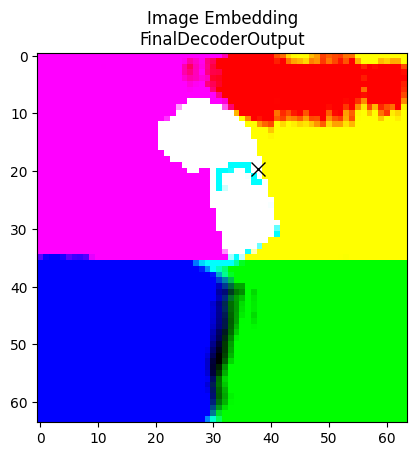

In [102]:
src_i = src[0, :, :] # [4096, 256]
src_i_cpu = src_i.squeeze().cpu().detach().numpy()
prompt_point = input_point * np.array((64 / 1920, (64 * (1080/1920)) / 1080))
training_data_src_i = src_i_cpu
reduced_data_src_i = pca.fit_transform(StandardScaler().fit_transform(training_data_src_i))
print(reduced_data_src_i.shape)
rgb_src_i = reduced_data_src_i.reshape(64, 64, 3)

plt.imshow(rgb_src_i)
point_color = 'black'
plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=10, marker="x", color=point_color)
plt.title('Image Embedding\nFinalDecoderOutput')
plt.savefig(str(output_path / "4-updated-image-embedding.png"), bbox_inches='tight')
plt.show()

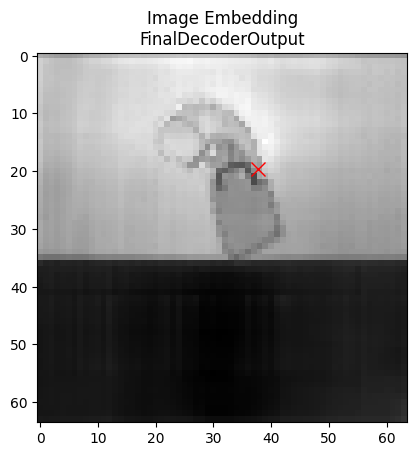

In [103]:
reduced_data_src_i_2 = pca_2.fit_transform(StandardScaler().fit_transform(training_data_src_i))
rgb_src_i_2 = reduced_data_src_i_2.reshape(64, 64)
# Visualize the tensor as a 64x64 image
plt.imshow(rgb_src_i_2, cmap='gray')
plt.title('Image Embedding\nFinalDecoderOutput')
point_color = "red"
plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=10, marker="x", color=point_color)
plt.savefig(str(output_path / "4-updated-image-embedding-gray.png"), bbox_inches='tight')
plt.show()

(4096, 10)


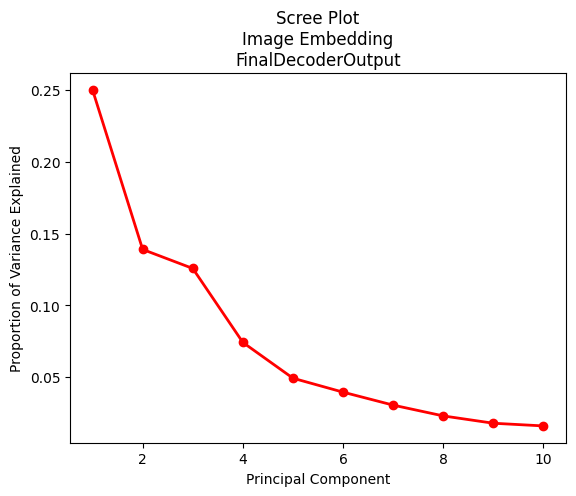

In [104]:
# Apply PCA
reduced_data_10 = pca_10.fit_transform(StandardScaler().fit_transform(training_data_src_i)) # (4096, 3)
print(reduced_data_10.shape)

PC_values = np.arange(pca_10.n_components_) + 1
plt.plot(PC_values, pca_10.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot\nImage Embedding\nFinalDecoderOutput')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.savefig(str(output_path / "4-updated-image-embedding-pca.png"), bbox_inches='tight')
plt.show()

# Upscale Updated Image Embeddings

In [105]:
# Upscale mask embeddings and predict masks using the mask tokens
src = src.transpose(1, 2).view(b, c, h, w)
upscaled_embedding = mask_decoder.output_upscaling(src)
b, c, h, w = upscaled_embedding.shape

In [106]:
print(b, c, h, w)

1 32 256 256


In [107]:
def viz_upscaled_img_embedding(upscaled_src):
    prompt_point = input_point * np.array((256 / 1920, (256 * (1080/1920)) / 1080))

    upscaled_embedding_i = upscaled_src[0, :, :, :] # (32, 256, 256)
    upscaled_embedding_i_cpu = upscaled_embedding_i.cpu().detach().numpy() # (32, 256, 256)
    training_data_upscaled_embedding_i = upscaled_embedding_i_cpu.reshape(32, 256 * 256).T # (256 x 256, 32)
    reduced_data_upscaled_embedding_i = pca.fit_transform(StandardScaler().fit_transform(training_data_upscaled_embedding_i)) # (256 x 256, 3)
    rgb_upscaled_embedding_i = reduced_data_upscaled_embedding_i.reshape(256, 256, 3)

    plt.imshow(rgb_upscaled_embedding_i)
    
    point_color = 'black'
    plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=10, marker="x", color=point_color)
    
    plt.title('Upscaled Updated Image Embedding')
    plt.savefig(str(output_path / "5-upscaled-image-embedding.png"), bbox_inches='tight')
    plt.show()

In [108]:
def viz_upscaled_img_embedding_gray_scale(upscaled_src):
    prompt_point = input_point * np.array((256 / 1920, (256 * (1080/1920)) / 1080))

    upscaled_embedding_i = upscaled_src[0, :, :, :] # (32, 256, 256)
    upscaled_embedding_i_cpu = upscaled_embedding_i.cpu().detach().numpy() # (32, 256, 256)
    training_data_upscaled_embedding_i = upscaled_embedding_i_cpu.reshape(32, 256 * 256).T # (256 x 256, 32)
    reduced_data_upscaled_embedding_i = pca_2.fit_transform(StandardScaler().fit_transform(training_data_upscaled_embedding_i)) # (256 x 256, 3)
    gray_upscaled_embedding_i = reduced_data_upscaled_embedding_i.reshape(256, 256, 1)

    plt.imshow(gray_upscaled_embedding_i, cmap='gray')
    
    point_color = 'red'
    plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=10, marker="x", color=point_color)
    
    plt.title('Upscaled Updated Image Embedding')
    plt.savefig(str(output_path / "5-upscaled-image-embedding-gray.png"), bbox_inches='tight')
    plt.show()

In [109]:
def viz_upscaled_img_embedding_pc(upscaled_src):
    upscaled_embedding_i = upscaled_src[0, :, :, :] # (32, 256, 256)
    upscaled_embedding_i_cpu = upscaled_embedding_i.cpu().detach().numpy() # (32, 256, 256)
    training_data_upscaled_embedding_i = upscaled_embedding_i_cpu.reshape(32, 256 * 256).T # (256 x 256, 32)
    reduced_data_10 = pca_10.fit_transform(StandardScaler().fit_transform(training_data_upscaled_embedding_i)) # (4096, 10)
    print(reduced_data_10.shape)

    PC_values = np.arange(pca_10.n_components_) + 1
    plt.plot(PC_values, pca_10.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot\nUpscaled Updated Image Embedding')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.savefig(str(output_path / "5-upscaled-image-embedding-pca.png"), bbox_inches='tight')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


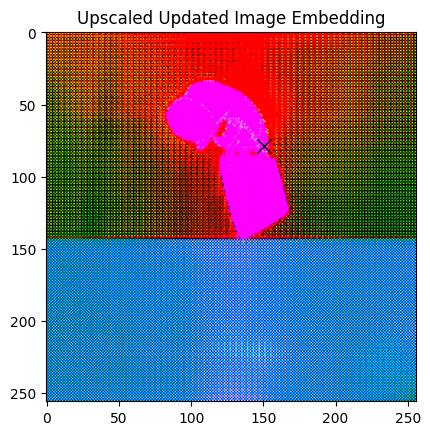

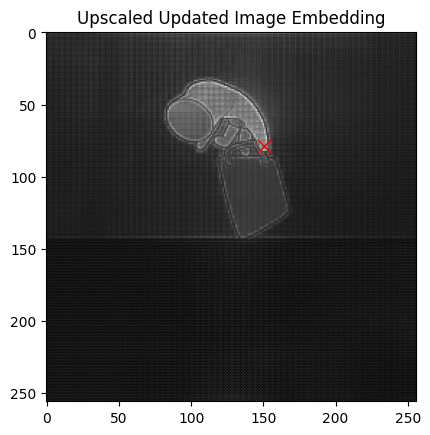

(65536, 10)


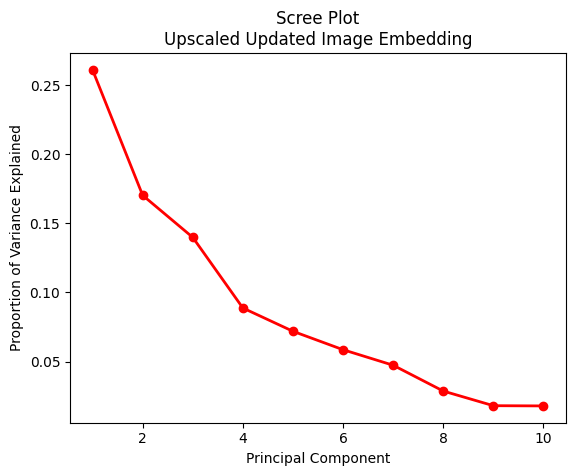

In [110]:
viz_upscaled_img_embedding(upscaled_embedding)
viz_upscaled_img_embedding_gray_scale(upscaled_embedding)
viz_upscaled_img_embedding_pc(upscaled_embedding)

# Pass updated tokens to corresponding MLPs

In [111]:
# Pass mask tokens to the corresponding MLP
hyper_in_list = []
for i in range(4):
    # 256-d to 32-d
    hyper_in_list.append(mask_decoder.output_hypernetworks_mlps[i](mask_tokens_out[:, i, :]))
hyper_in = torch.stack(hyper_in_list, dim=1)

In [112]:
print(hyper_in.shape)

torch.Size([1, 4, 32])


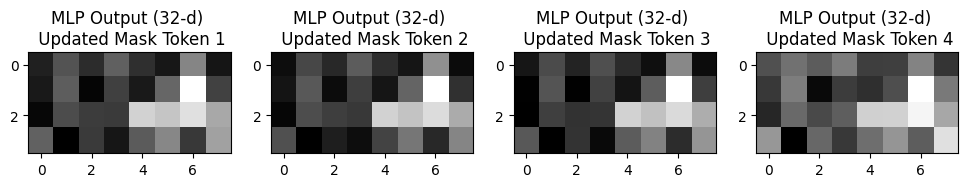

In [113]:
fig = plt.figure(figsize=(12, 3.5))
for i in range(4):
    mlp_output_token_i = hyper_in_list[i]
    mlp_output_token_i_cpu = mlp_output_token_i.cpu().detach().numpy() # [1, 32]
    mlp_output_token_i_cpu_gray = mlp_output_token_i_cpu.reshape(4, 8) # [16, 16]

    plt.subplot(1, 4, i+1)
    plt.title('MLP Output (32-d) \n Updated Mask Token %d' % (i+1))
    plt.imshow(mlp_output_token_i_cpu_gray, cmap='gray')
plt.savefig(str(output_path / "5-mlp-updated-mask-tokens.png"), bbox_inches='tight')
plt.show()

# Dot product to get Low-Resolution Masks

In [114]:
# Dot product upscaled_embedding and hyper_in to get the masks
#        [1, 4, 32-d] @ [1, 32-d, 256 x 256] = [1, 4, 256 x 256] (32-d is cancelled out)
masks = (hyper_in @ upscaled_embedding.view(b, c, h * w)).view(b, -1, h, w)

In [115]:
print(masks.shape)

torch.Size([1, 4, 256, 256])


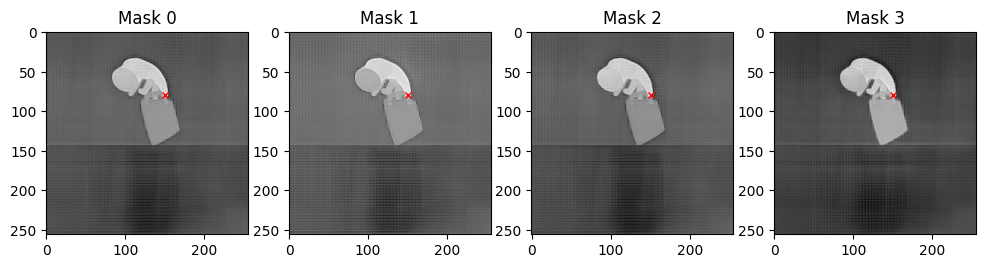

In [116]:
fig = plt.figure(figsize=(12, 3.5))
for mask_id in range(4):

    curr_mask = masks[0, mask_id, :, :]
    curr_mask_cpu = curr_mask.cpu().detach().numpy()

    prompt_point = input_point * np.array((256 / 1920, (256 * (1080/1920)) / 1080))

    plt.subplot(1, 4, mask_id+1)
    point_color = "red"
    plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=5, marker="x", color=point_color)
    plt.title(f"Mask {mask_id}")
    plt.imshow(curr_mask_cpu, cmap='gray')

plt.show()

In [117]:
print(masks.shape)

torch.Size([1, 4, 256, 256])


# IoU Prediction

In [118]:
# Generate mask quality predictions
iou_pred = mask_decoder.iou_prediction_head(iou_token_out)

In [119]:
print(iou_pred.shape) # [64, 4]

torch.Size([1, 4])


In [120]:
print(iou_pred)

tensor([[0.8802, 0.8922, 1.0036, 0.9812]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [121]:
# Select the correct mask or masks for output
multimask_output = True
if multimask_output:
    mask_slice = slice(1, None)
else:
    mask_slice = slice(0, 1)
masks = masks[:, mask_slice, :, :]
iou_pred = iou_pred[:, mask_slice]

In [122]:
print(masks.shape)
print(iou_pred.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3])


In [123]:
print(iou_pred)

tensor([[0.8922, 1.0036, 0.9812]], device='cuda:0', grad_fn=<SliceBackward0>)


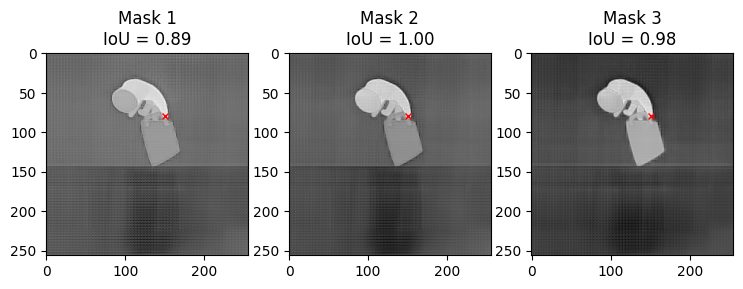

In [124]:
fig = plt.figure(figsize=(12, 3.5))
for mask_id in range(3):

    curr_mask = masks[0, mask_id, :, :]
    iou_score = iou_pred[0, mask_id]
    curr_mask_cpu = curr_mask.cpu().detach().numpy()

    prompt_point = input_point * np.array((256 / 1920, (256 * (1080/1920)) / 1080))

    plt.subplot(1, 4, mask_id+1)
    point_color = "red"
    plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=5, marker="x", color=point_color)
    plt.title(f"Mask {mask_id+1}\nIoU = {iou_score:.2f}")
    plt.imshow(curr_mask_cpu, cmap='gray')

plt.savefig(str(output_path / "6-low-res-masks.png"), bbox_inches='tight')
plt.show()

# Remove padding and Upscaling Masks to original image size

In [125]:
print(predictor.input_size)
print(predictor.original_size)

(576, 1024)
(1080, 1920)


In [126]:
1024 * (1080 / 1920)

576.0

In [127]:
print(masks.shape)

torch.Size([1, 3, 256, 256])


In [128]:
original_res_masks = predictor.model.postprocess_masks(masks, predictor.input_size, predictor.original_size)

In [129]:
print(original_res_masks.shape)

torch.Size([1, 3, 1080, 1920])


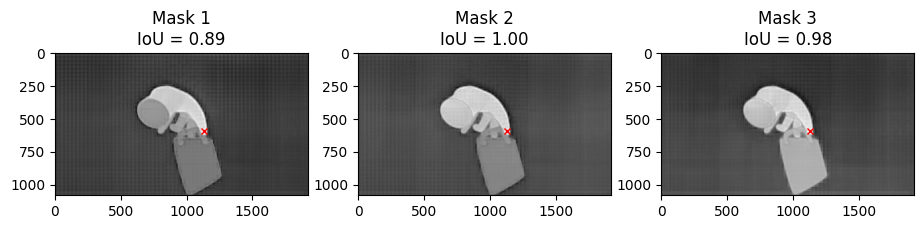

In [130]:
fig = plt.figure(figsize=(15, 3.5))
for mask_id in range(3):

    curr_mask = original_res_masks[0, mask_id, :, :]
    iou_score = iou_pred[0, mask_id]
    curr_mask_cpu = curr_mask.cpu().detach().numpy()

    prompt_point = input_point

    plt.subplot(1, 4, mask_id+1)
    point_color = "red"
    plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=5, marker="x", color=point_color)
    plt.title(f"Mask {mask_id+1}\nIoU = {iou_score:.2f}")
    plt.imshow(curr_mask_cpu, cmap='gray')

plt.savefig(str(output_path / "7-original-res-masks.png"), bbox_inches='tight')
plt.show()

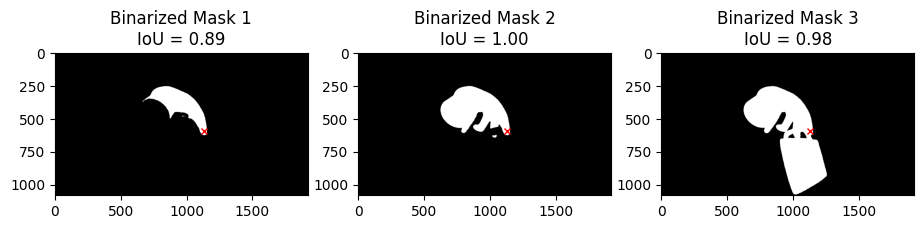

In [131]:
# Binarize masks
fig = plt.figure(figsize=(15, 3.5))
for mask_id in range(3):

    curr_mask = original_res_masks[0, mask_id, :, :]
    iou_score = iou_pred[0, mask_id]

    # Save Binarized masks
    bi_curr_mask = curr_mask > predictor.model.mask_threshold
    curr_mask_cpu = bi_curr_mask.cpu().detach().numpy()

    prompt_point = input_point

    plt.subplot(1, 4, mask_id+1)
    point_color = "red"
    plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=5, marker="x", color=point_color)
    plt.title(f"Binarized Mask {mask_id+1}\nIoU = {iou_score:.2f}")
    plt.imshow(curr_mask_cpu, cmap='gray')

plt.savefig(str(output_path / "8-binarized-masks.png"), bbox_inches='tight')
plt.show()

# Directly get the Mask Results

All the above visualization are intermediate steps inside `SamPredictor.predict()` to get the following mask results.

In [132]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [133]:
masks.shape  # (number_of_masks) x H x W

(3, 1080, 1920)

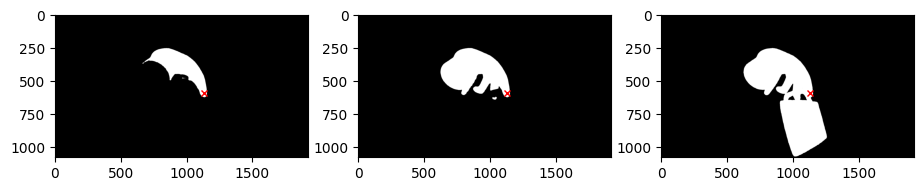

In [134]:
fig = plt.figure(figsize=(15, 3.5))
for mask_id in range(3):

    curr_mask = masks[mask_id, :, :]
    
    prompt_point = input_point

    plt.subplot(1, 4, mask_id+1)
    point_color = "red"
    plt.plot(prompt_point[0, 0], prompt_point[0, 1], markersize=5, marker="x", color=point_color)
    plt.imshow(curr_mask, cmap='gray')

plt.show()

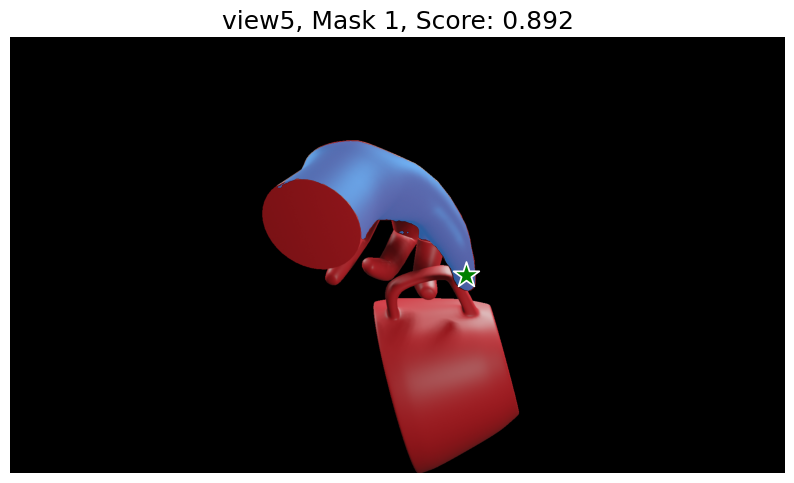

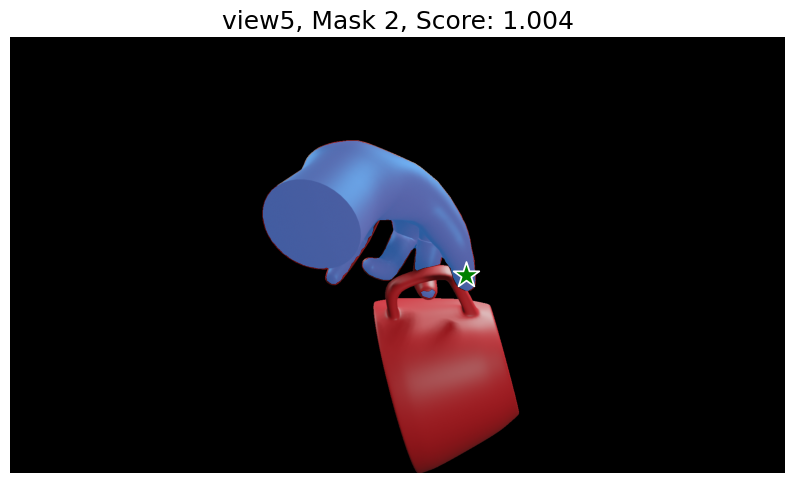

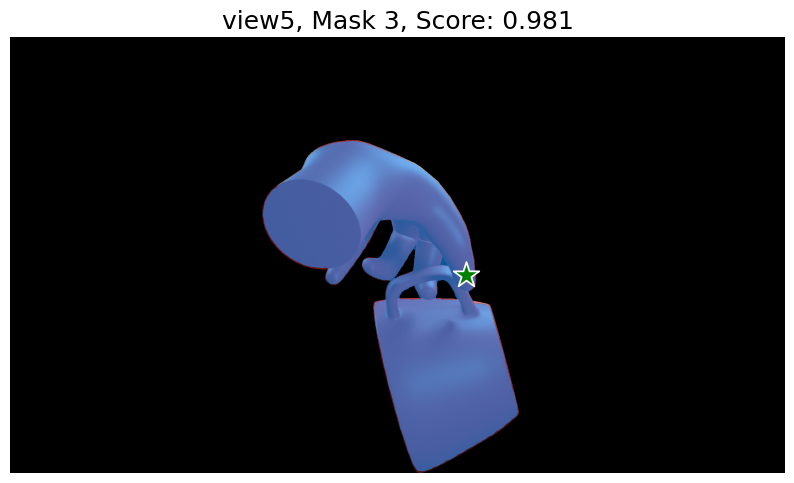

In [135]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(curr_img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"{curr_view}, Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

# Getting RGBA image by Concatenating Mask as Alpha channel 

Turn original RGB image into RGBA image as required by NeuS2: 
* If a pixel is in background (mask gray value == 0), turn alpha to 0.
* If a pixel is in foreground / segmented as part of the object of interest (mask gray value == 1 / 255), turn alpha to 1 / 255.

In [136]:
print(curr_img.shape)

(1080, 1920, 3)


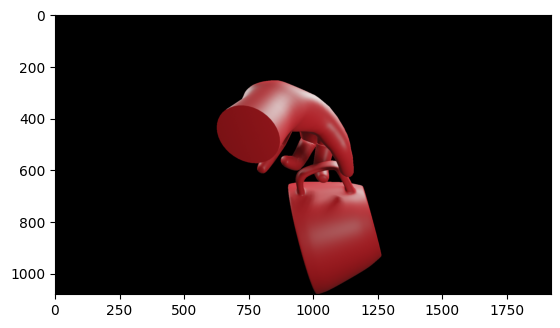

In [137]:
plt.imshow(curr_img)
plt.show()

In [138]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = mask.astype(int)
    mask[mask != 0] = 255
    
    curr_img_BGR = cv2.cvtColor(curr_img, cv2.COLOR_RGB2BGR)
    concat_image = np.concatenate([curr_img_BGR, mask[:, :, np.newaxis]], axis=-1)

    output_folder = output_path / "final"
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    cv2.imwrite(str(output_folder / f"{curr_view}_part_{i+1}.png"), concat_image)